In [1]:
#load libraries
import pandas as pd
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima 


C:\Users\User\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#load folder-the actual data were given in 17 separate excel files
files = os.listdir('dataLoad')
files

['Cons_Report_012018.xlsx',
 'Cons_Report_012019.xlsx',
 'Cons_Report_022018.xlsx',
 'Cons_Report_022019.xlsx',
 'Cons_Report_032018.xlsx',
 'Cons_Report_032019.xlsx',
 'Cons_Report_042018.xlsx',
 'Cons_Report_042019.xlsx',
 'Cons_Report_052018.xlsx',
 'Cons_Report_052019.xlsx',
 'Cons_Report_062018.xlsx',
 'Cons_Report_062019.xlsx',
 'Cons_Report_072018.xlsx',
 'Cons_Report_072019.xlsx',
 'Cons_Report_082018.xlsx',
 'Cons_Report_082019.xlsx',
 'Cons_Report_092018.xlsx',
 'Cons_Report_092019.xlsx',
 'Cons_Report_102018.xlsx',
 'Cons_Report_102019.xlsx',
 'Cons_Report_112018.xlsx',
 'Cons_Report_122018.xlsx',
 'Load Demand_Forecast.xlsx']

In [3]:
#list of files to loop-only xlsx
files_xls = [f for f in files if 'Cons_Report' in f]
files_xls

['Cons_Report_012018.xlsx',
 'Cons_Report_012019.xlsx',
 'Cons_Report_022018.xlsx',
 'Cons_Report_022019.xlsx',
 'Cons_Report_032018.xlsx',
 'Cons_Report_032019.xlsx',
 'Cons_Report_042018.xlsx',
 'Cons_Report_042019.xlsx',
 'Cons_Report_052018.xlsx',
 'Cons_Report_052019.xlsx',
 'Cons_Report_062018.xlsx',
 'Cons_Report_062019.xlsx',
 'Cons_Report_072018.xlsx',
 'Cons_Report_072019.xlsx',
 'Cons_Report_082018.xlsx',
 'Cons_Report_082019.xlsx',
 'Cons_Report_092018.xlsx',
 'Cons_Report_092019.xlsx',
 'Cons_Report_102018.xlsx',
 'Cons_Report_102019.xlsx',
 'Cons_Report_112018.xlsx',
 'Cons_Report_122018.xlsx']

In [4]:
#create one dataframe from all the excel files
actual = pd.DataFrame()
for f in files_xls:
    data = pd.read_excel('dataLoad/' + f)
    actual=actual.append(data, ignore_index=True)

In [5]:
#get column names
actual.columns

Index(['deliveryDay', 'Hour_EET', 'Gen_Aux', 'HV', 'Pump', 'TEL_MV', 'Network',
       'Total'],
      dtype='object')

In [6]:
#rename columns
actual.columns=['Date','Hour','Gen_Aux', 'HV', 'Pump', 'TEL_MV', 'Network','ActualTotal']
actual.head(10)

,Date,Hour,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal
0,2018-01-01,1,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918
1,2018-01-01,2,40.928810,760.024989,0.000,589.266551,4205.128845,5006.082645
2,2018-01-01,3,39.286246,750.624526,0.000,585.334471,4116.742544,4906.653316
3,2018-01-01,4,38.678094,756.567856,0.120,582.210175,3833.136857,4628.502808
4,2018-01-01,5,37.498531,731.949138,130.176,581.251131,3608.455842,4508.079510
5,2018-01-01,6,37.843782,751.929837,358.482,592.809796,3527.228368,4675.483986
6,2018-01-01,7,38.717082,746.040356,365.631,609.285487,3600.189330,4750.577768
7,2018-01-01,8,38.556936,729.051897,256.673,619.337395,3667.999929,4692.281762
8,2018-01-01,9,37.718306,753.256276,248.236,614.221973,3803.437022,4842.647604
9,2018-01-01,10,38.377740,745.177096,11.874,621.179152,4196.899298,4992.328134


In [7]:
#load excel with forecast of the current program
forecast=pd.read_excel("dataLoad/Load Demand_Forecast.xlsx")

In [8]:
#data manipulation to create new dataframe
forecast2=forecast[['Weekday',  'Holiday','Date', 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]]
prediction = pd.melt(forecast2, id_vars=["Weekday", "Holiday", "Date"])
prediction.head(10)

,Weekday,Holiday,Date,variable,value
0,1,1,2018-01-01,1,5315.0
1,2,0,2018-01-02,1,5023.0
2,3,0,2018-01-03,1,5211.0
3,4,0,2018-01-04,1,5307.0
4,5,0,2018-01-05,1,5420.0
5,6,1,2018-01-06,1,5430.0
6,7,0,2018-01-07,1,5348.0
7,1,0,2018-01-08,1,5170.0
8,2,0,2018-01-09,1,5343.0
9,3,0,2018-01-10,1,5304.0


In [9]:
#rename columns
prediction.columns=[ 'Weekday', 'Holiday', 'Date', 'Hour', 'ForecastTotalLoad' ]
prediction.head(10)

,Weekday,Holiday,Date,Hour,ForecastTotalLoad
0,1,1,2018-01-01,1,5315.0
1,2,0,2018-01-02,1,5023.0
2,3,0,2018-01-03,1,5211.0
3,4,0,2018-01-04,1,5307.0
4,5,0,2018-01-05,1,5420.0
5,6,1,2018-01-06,1,5430.0
6,7,0,2018-01-07,1,5348.0
7,1,0,2018-01-08,1,5170.0
8,2,0,2018-01-09,1,5343.0
9,3,0,2018-01-10,1,5304.0


In [10]:
#subtract one hour to get to 0-23 hour format
actual['Hour']=actual['Hour']-1
prediction['Hour']=prediction['Hour']-1

In [11]:
#set index
actual.set_index(['Date', 'Hour']).head()

Gen_Aux          HV     Pump      TEL_MV      Network  \
Date       Hour                                                            
2018-01-01 0     34.418093  757.020147    0.000  596.563993  4529.773678   
           1     40.928810  760.024989    0.000  589.266551  4205.128845   
           2     39.286246  750.624526    0.000  585.334471  4116.742544   
           3     38.678094  756.567856    0.120  582.210175  3833.136857   
           4     37.498531  731.949138  130.176  581.251131  3608.455842   

                 ActualTotal  
Date       Hour               
2018-01-01 0     5321.211918  
           1     5006.082645  
           2     4906.653316  
           3     4628.502808  
           4     4508.079510

In [12]:
#set index
prediction.set_index(['Date', 'Hour']).head()

,,Weekday,Holiday,ForecastTotalLoad
Date,Hour,,,
2018-01-01,0,1,1,5315.0
2018-01-02,0,2,0,5023.0
2018-01-03,0,3,0,5211.0
2018-01-04,0,4,0,5307.0
2018-01-05,0,5,0,5420.0


In [13]:
#merge datasets
final = pd.merge(prediction, actual, on=['Date', 'Hour'])
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918
1,2,0,2018-01-02,0,5023.0,45.218816,751.513843,0.000,610.814364,4101.718326,4898.450985
2,3,0,2018-01-03,0,5211.0,37.042898,904.679508,0.000,800.563658,4283.392261,5225.114667
3,4,0,2018-01-04,0,5307.0,35.636497,918.203986,0.000,853.288369,4450.591164,5404.431647
4,5,0,2018-01-05,0,5420.0,37.712368,961.116481,23.108,866.047536,4617.594242,5639.531090


In [14]:
#create Timestamp column
final['Timestamp'] = final['Date'] + pd.to_timedelta(final['Hour'], unit='h')
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01
1,2,0,2018-01-02,0,5023.0,45.218816,751.513843,0.000,610.814364,4101.718326,4898.450985,2018-01-02
2,3,0,2018-01-03,0,5211.0,37.042898,904.679508,0.000,800.563658,4283.392261,5225.114667,2018-01-03
3,4,0,2018-01-04,0,5307.0,35.636497,918.203986,0.000,853.288369,4450.591164,5404.431647,2018-01-04
4,5,0,2018-01-05,0,5420.0,37.712368,961.116481,23.108,866.047536,4617.594242,5639.531090,2018-01-05


In [15]:
#sort by timestamp
final.sort_values('Timestamp', inplace=True)
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01 00:00:00
669,1,1,2018-01-01,1,4963.0,40.928810,760.024989,0.000,589.266551,4205.128845,5006.082645,2018-01-01 01:00:00
1338,1,1,2018-01-01,2,4838.0,39.286246,750.624526,0.000,585.334471,4116.742544,4906.653316,2018-01-01 02:00:00
2007,1,1,2018-01-01,3,4515.0,38.678094,756.567856,0.120,582.210175,3833.136857,4628.502808,2018-01-01 03:00:00
2676,1,1,2018-01-01,4,4280.0,37.498531,731.949138,130.176,581.251131,3608.455842,4508.079510,2018-01-01 04:00:00


In [16]:
#create the column of interest
final['LV'] = final['Network'] - final['TEL_MV']

#find the percentage of XT as to total ActualLoad for that day and Hour (TrueValues)
final['%LVofTotal']=final['LV']/final['ActualTotal']

#find the estimation of XTPrediction
final['LVForecastEstimation']=final['%LVofTotal']*final['ForecastTotalLoad']

final['Deviation']=final['ActualTotal']-final['ForecastTotalLoad']

In [17]:
final

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp,LV,%LVofTotal,LVForecastEstimation,Deviation
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01 00:00:00,3933.209685,0.739157,3928.618104,6.211918
669,1,1,2018-01-01,1,4963.0,40.928810,760.024989,0.000,589.266551,4205.128845,5006.082645,2018-01-01 01:00:00,3615.862294,0.722294,3584.743969,43.082645
1338,1,1,2018-01-01,2,4838.0,39.286246,750.624526,0.000,585.334471,4116.742544,4906.653316,2018-01-01 02:00:00,3531.408073,0.719718,3481.997027,68.653316
2007,1,1,2018-01-01,3,4515.0,38.678094,756.567856,0.120,582.210175,3833.136857,4628.502808,2018-01-01 03:00:00,3250.926682,0.702371,3171.205588,113.502808
2676,1,1,2018-01-01,4,4280.0,37.498531,731.949138,130.176,581.251131,3608.455842,4508.079510,2018-01-01 04:00:00,3027.204711,0.671507,2874.047836,228.079510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13379,4,0,2019-10-31,19,6011.0,25.846024,730.420719,0.000,1339.675368,5390.350421,6146.617165,2019-10-31 19:00:00,4050.675054,0.659009,3961.302143,135.617165
14048,4,0,2019-10-31,20,5913.0,26.163921,723.475186,0.000,1311.226656,5309.782663,6059.421771,2019-10-31 20:00:00,3998.556006,0.659891,3901.933643,146.421771
14717,4,0,2019-10-31,21,5523.0,26.181055,723.925940,0.000,1218.650557,4899.784871,5649.891865,2019-10-31 21:00:00,3681.134314,0.651541,3598.459103,126.891865
15386,4,0,2019-10-31,22,5005.0,29.782536,676.712986,97.617,1121.828436,4351.407631,5155.520153,2019-10-31 22:00:00,3229.579195,0.626431,3135.288660,150.520153


In [18]:
#finalize dataset and set frequency
final=final[['Timestamp','LV','Weekday','Holiday','LVForecastEstimation','%LVofTotal','ActualTotal','Deviation','ForecastTotalLoad']]
final.sort_values('Timestamp', inplace=True)
final.set_index('Timestamp', inplace=True)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
final.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-10-31 14:00:00', '2019-10-31 15:00:00',
               '2019-10-31 16:00:00', '2019-10-31 17:00:00',
               '2019-10-31 18:00:00', '2019-10-31 19:00:00',
               '2019-10-31 20:00:00', '2019-10-31 21:00:00',
               '2019-10-31 22:00:00', '2019-10-31 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=16054, freq=None)

In [20]:
#check for missing values
pd.date_range(final.index.min(), final.index.max(), freq='H').difference(final.index)

DatetimeIndex(['2018-03-25 23:00:00', '2019-03-31 23:00:00'], dtype='datetime64[ns]', freq=None)

In [21]:
#set Hourly index frequency
final = final.asfreq(freq='H', method='pad')
final.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-10-31 14:00:00', '2019-10-31 15:00:00',
               '2019-10-31 16:00:00', '2019-10-31 17:00:00',
               '2019-10-31 18:00:00', '2019-10-31 19:00:00',
               '2019-10-31 20:00:00', '2019-10-31 21:00:00',
               '2019-10-31 22:00:00', '2019-10-31 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=16056, freq='H')

In [22]:
#check again for NaN in dataframe γιατι τώρα που κουβαλάω και την επιπλέον στήλη εχω το ίδιο θέμα με την ώρα
final[final.isnull().any(axis=1)]

,LV,Weekday,Holiday,LVForecastEstimation,%LVofTotal,ActualTotal,Deviation,ForecastTotalLoad
Timestamp,,,,,,,,
2018-03-25 03:00:00,2507.887529,7,1,NaN,0.589349,4255.350588,NaN,NaN


In [23]:
#NaN that day for forecastedValues
final.loc['2018-03-25 03:00:00']

LV                      2507.887529
Weekday                    7.000000
Holiday                    1.000000
LVForecastEstimation            NaN
%LVofTotal                 0.589349
ActualTotal             4255.350588
Deviation                       NaN
ForecastTotalLoad               NaN
Name: 2018-03-25 03:00:00, dtype: float64

In [24]:
#fill with previous value ΝαΝ
final=final.fillna(method='ffill')

In [25]:
#fixed
final.loc['2018-03-25 03:00:00']

LV                      2507.887529
Weekday                    7.000000
Holiday                    1.000000
LVForecastEstimation    2648.583949
%LVofTotal                 0.589349
ActualTotal             4255.350588
Deviation                  9.662458
ForecastTotalLoad       4430.000000
Name: 2018-03-25 03:00:00, dtype: float64

In [26]:
final

,LV,Weekday,Holiday,LVForecastEstimation,%LVofTotal,ActualTotal,Deviation,ForecastTotalLoad
Timestamp,,,,,,,,
2018-01-01 00:00:00,3933.209685,1,1,3928.618104,0.739157,5321.211918,6.211918,5315.0
2018-01-01 01:00:00,3615.862294,1,1,3584.743969,0.722294,5006.082645,43.082645,4963.0
2018-01-01 02:00:00,3531.408073,1,1,3481.997027,0.719718,4906.653316,68.653316,4838.0
2018-01-01 03:00:00,3250.926682,1,1,3171.205588,0.702371,4628.502808,113.502808,4515.0
2018-01-01 04:00:00,3027.204711,1,1,2874.047836,0.671507,4508.079510,228.079510,4280.0
...,...,...,...,...,...,...,...,...
2019-10-31 19:00:00,4050.675054,4,0,3961.302143,0.659009,6146.617165,135.617165,6011.0
2019-10-31 20:00:00,3998.556006,4,0,3901.933643,0.659891,6059.421771,146.421771,5913.0
2019-10-31 21:00:00,3681.134314,4,0,3598.459103,0.651541,5649.891865,126.891865,5523.0


# Data Exploration

Text(0.5, 1.0, 'Low Voltage Load Demand VS Holiday')

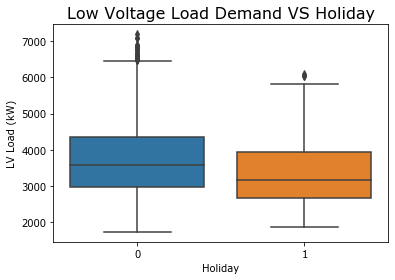

In [27]:
#Here is going to be the EDA part-just some quick insights
import seaborn as sns
sns.boxplot(x=final['Holiday'],y=final['LV']).set(ylabel='LV Load (kW)',xlabel='Holiday')
plt.title('Low Voltage Load Demand VS Holiday',fontsize=16)

Text(0.5, 1.0, 'Low Voltage Load Demand VS Weekday')

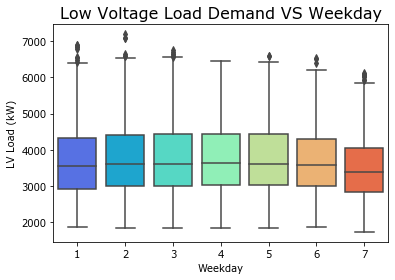

In [28]:
sns.boxplot(x=final['Weekday'],y=final['LV'],palette='rainbow').set(ylabel='LV Load (kW)',xlabel='Weekday')
plt.title('Low Voltage Load Demand VS Weekday',fontsize=16)

Text(0.5, 1.0, 'Low Voltage Load Demand')

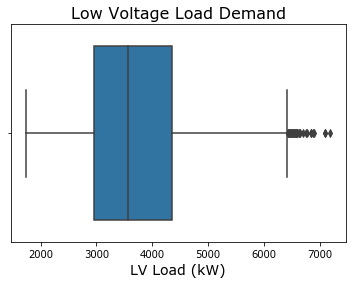

In [29]:
#there are some outliers
sns.boxplot(x=final['LV']).set_xlabel('LV Load (kW)',fontsize=14)
plt.title('Low Voltage Load Demand',fontsize=16)


In [30]:
#check largest Values-seems logical not extreme values
print( final['LV'].nlargest(100))

Timestamp
2019-01-08 19:00:00    7187.273484
2019-01-08 18:00:00    7092.001648
2019-01-08 20:00:00    7087.291997
2019-01-07 19:00:00    6889.243639
2018-12-31 19:00:00    6886.460958
                          ...     
2019-02-13 20:00:00    6129.427284
2019-08-02 17:00:00    6128.394761
2019-02-24 12:00:00    6126.753362
2019-08-01 16:00:00    6124.848840
2018-12-13 20:00:00    6123.033986
Name: LV, Length: 100, dtype: float64


Text(0.5, 1.0, 'Daily Actual LV Load Demand per Hour')

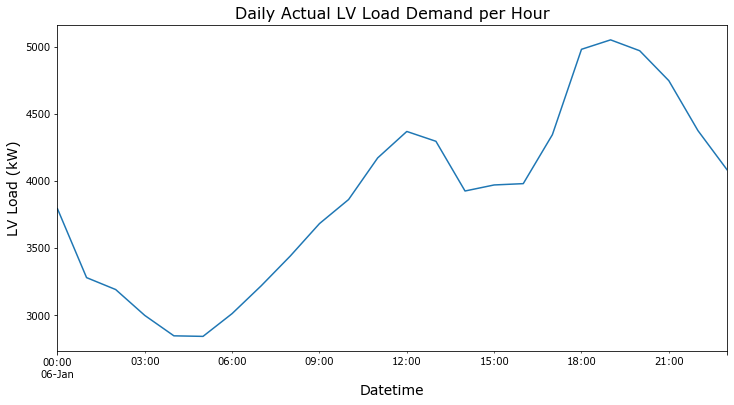

In [31]:
final['LV'].iloc[120:144].plot(figsize=(12,6)).autoscale(axis='x',tight=True);
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('LV Load (kW)', fontsize=14)
plt.title('Daily Actual LV Load Demand per Hour', fontsize=16)

Text(0.5, 1.0, '2018 Actual LV Load Demand (Historical Data)')

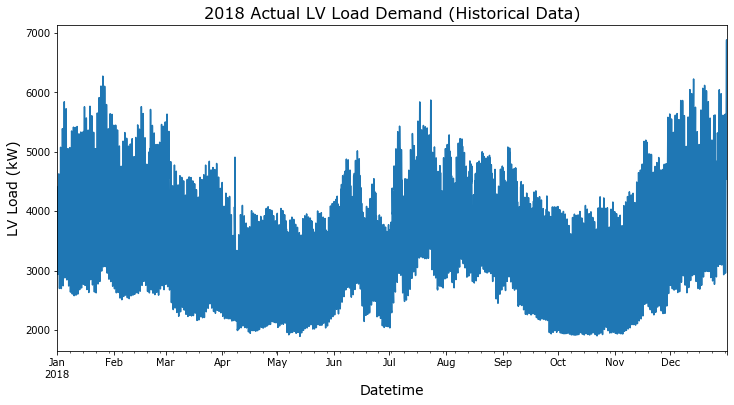

In [32]:
final['LV'].loc['2018-01-01':'2018-12-31'].plot(figsize=(12,6)).autoscale(axis='x',tight=True);
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('LV Load (kW)', fontsize=14)
plt.title('2018 Actual LV Load Demand (Historical Data)', fontsize=16)

Text(0, 0.5, 'Residual')

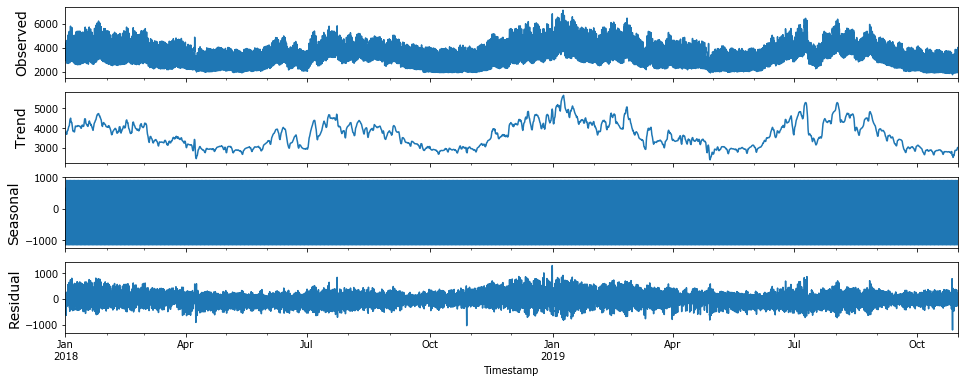

In [33]:
fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(16,6))

result = seasonal_decompose(final['LV'])

result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed',fontsize=14)
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend',fontsize=14)
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal',fontsize=14)
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual',fontsize=14)


In [34]:
#create ad-fuller test function
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [35]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

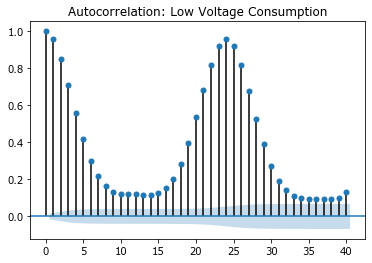

In [36]:
# Now let's plot the autocorrelation at different lags
title = 'Autocorrelation: Low Voltage Consumption'
lags = 40
plot_acf(final['LV'],title=title,lags=lags);

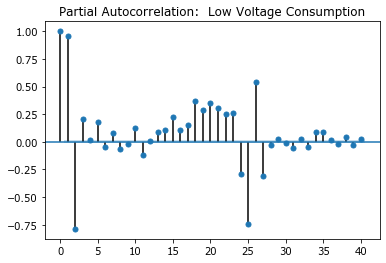

In [37]:
title='Partial Autocorrelation:  Low Voltage Consumption'
lags=40
plot_pacf(final['LV'],title=title,lags=lags);

In [38]:
#KPSS test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(series):
    print ('Results of KPSS Test:')
    kpsstest = kpss(series, regression='c', lags='auto')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [39]:
kpss_test(final['LV'])

Results of KPSS Test:
Test Statistic            0.698710
p-value                   0.013663
Lags Used                59.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [40]:
adf_test(final['LV'])

Augmented Dickey-Fuller Test: 
ADF test statistic         -3.936734
p-value                     0.001781
# lags used                43.000000
# observations          16012.000000
critical value (1%)        -3.430758
critical value (5%)        -2.861721
critical value (10%)       -2.566866
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [41]:
final2=final

In [42]:
final2

,LV,Weekday,Holiday,LVForecastEstimation,%LVofTotal,ActualTotal,Deviation,ForecastTotalLoad
Timestamp,,,,,,,,
2018-01-01 00:00:00,3933.209685,1,1,3928.618104,0.739157,5321.211918,6.211918,5315.0
2018-01-01 01:00:00,3615.862294,1,1,3584.743969,0.722294,5006.082645,43.082645,4963.0
2018-01-01 02:00:00,3531.408073,1,1,3481.997027,0.719718,4906.653316,68.653316,4838.0
2018-01-01 03:00:00,3250.926682,1,1,3171.205588,0.702371,4628.502808,113.502808,4515.0
2018-01-01 04:00:00,3027.204711,1,1,2874.047836,0.671507,4508.079510,228.079510,4280.0
...,...,...,...,...,...,...,...,...
2019-10-31 19:00:00,4050.675054,4,0,3961.302143,0.659009,6146.617165,135.617165,6011.0
2019-10-31 20:00:00,3998.556006,4,0,3901.933643,0.659891,6059.421771,146.421771,5913.0
2019-10-31 21:00:00,3681.134314,4,0,3598.459103,0.651541,5649.891865,126.891865,5523.0


### Calculate Percentage for Future ADMHE Prediction Adjustment 
### and inserting it into model

In [43]:
final3=final2.copy()

In [44]:
final3

,LV,Weekday,Holiday,LVForecastEstimation,%LVofTotal,ActualTotal,Deviation,ForecastTotalLoad
Timestamp,,,,,,,,
2018-01-01 00:00:00,3933.209685,1,1,3928.618104,0.739157,5321.211918,6.211918,5315.0
2018-01-01 01:00:00,3615.862294,1,1,3584.743969,0.722294,5006.082645,43.082645,4963.0
2018-01-01 02:00:00,3531.408073,1,1,3481.997027,0.719718,4906.653316,68.653316,4838.0
2018-01-01 03:00:00,3250.926682,1,1,3171.205588,0.702371,4628.502808,113.502808,4515.0
2018-01-01 04:00:00,3027.204711,1,1,2874.047836,0.671507,4508.079510,228.079510,4280.0
...,...,...,...,...,...,...,...,...
2019-10-31 19:00:00,4050.675054,4,0,3961.302143,0.659009,6146.617165,135.617165,6011.0
2019-10-31 20:00:00,3998.556006,4,0,3901.933643,0.659891,6059.421771,146.421771,5913.0
2019-10-31 21:00:00,3681.134314,4,0,3598.459103,0.651541,5649.891865,126.891865,5523.0


In [45]:
final3['Timestamp']=final3.index
final3['Month'] = pd.to_numeric(final3['Timestamp'].dt.strftime('%m'))
final3['Year'] = pd.to_numeric(final3['Timestamp'].dt.strftime('%Y'))
final3['Hour'] = pd.to_numeric(final3['Timestamp'].dt.strftime('%H'))

In [46]:
final3

,LV,Weekday,Holiday,LVForecastEstimation,%LVofTotal,ActualTotal,Deviation,ForecastTotalLoad,Timestamp,Month,Year,Hour
Timestamp,,,,,,,,,,,,
2018-01-01 00:00:00,3933.209685,1,1,3928.618104,0.739157,5321.211918,6.211918,5315.0,2018-01-01 00:00:00,1,2018,0
2018-01-01 01:00:00,3615.862294,1,1,3584.743969,0.722294,5006.082645,43.082645,4963.0,2018-01-01 01:00:00,1,2018,1
2018-01-01 02:00:00,3531.408073,1,1,3481.997027,0.719718,4906.653316,68.653316,4838.0,2018-01-01 02:00:00,1,2018,2
2018-01-01 03:00:00,3250.926682,1,1,3171.205588,0.702371,4628.502808,113.502808,4515.0,2018-01-01 03:00:00,1,2018,3
2018-01-01 04:00:00,3027.204711,1,1,2874.047836,0.671507,4508.079510,228.079510,4280.0,2018-01-01 04:00:00,1,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-31 19:00:00,4050.675054,4,0,3961.302143,0.659009,6146.617165,135.617165,6011.0,2019-10-31 19:00:00,10,2019,19
2019-10-31 20:00:00,3998.556006,4,0,3901.933643,0.659891,6059.421771,146.421771,5913.0,2019-10-31 20:00:00,10,2019,20
2019-10-31 21:00:00,3681.134314,4,0,3598.459103,0.651541,5649.891865,126.891865,5523.0,2019-10-31 21:00:00,10,2019,21


In [107]:
final3=final3[['Weekday','Holiday','ForecastTotalLoad','Month','Year','Hour','%LVofTotal']]

In [108]:
final3

,Weekday,Holiday,ForecastTotalLoad,Month,Year,Hour,%LVofTotal
Timestamp,,,,,,,
2018-01-01 00:00:00,1,1,5315.0,1,2018,0,0.739157
2018-01-01 01:00:00,1,1,4963.0,1,2018,1,0.722294
2018-01-01 02:00:00,1,1,4838.0,1,2018,2,0.719718
2018-01-01 03:00:00,1,1,4515.0,1,2018,3,0.702371
2018-01-01 04:00:00,1,1,4280.0,1,2018,4,0.671507
...,...,...,...,...,...,...,...
2019-10-31 19:00:00,4,0,6011.0,10,2019,19,0.659009
2019-10-31 20:00:00,4,0,5913.0,10,2019,20,0.659891
2019-10-31 21:00:00,4,0,5523.0,10,2019,21,0.651541


In [48]:
X_train=final3.loc[:'2019-09-14'][['Weekday','Holiday','ForecastTotalLoad','Month','Year','Hour']]
y_train=final3.loc[:'2019-09-14']['%LVofTotal']

In [49]:
X_test=final3.loc['2019-09-15'][['Weekday','Holiday','ForecastTotalLoad','Month','Year','Hour']]
y_test=final3.loc['2019-09-15']['%LVofTotal'].to_frame()

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import lightgbm as ltb

In [51]:
rfc=ltb.LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=1200,
                                learning_rate=0.17, n_estimators=700, max_depth=6,
                                metric='rmse', bagging_fraction=0.8, feature_fraction=0.8, reg_lambda=0.9)

In [52]:
#fit the model to calculate percentage of LV (You can not know it before)
f=rfc.fit(X_train,y_train)

In [53]:
#make predictions for percentage
y_1= f.predict(X_test)

In [54]:
#the predictions on what to expect for 
y_1

array([0.59316212, 0.56232624, 0.54530453, 0.53764897, 0.5370101 ,
       0.54025775, 0.54828272, 0.5658573 , 0.5923241 , 0.61898232,
       0.64431985, 0.65625407, 0.6591821 , 0.65372303, 0.64521666,
       0.62001059, 0.6176629 , 0.62170736, 0.63284483, 0.65838419,
       0.66647305, 0.6623705 , 0.6558857 , 0.63493357])

In [55]:
#what ADMHE predicted on the specific day for the whole network
p=prediction.loc[prediction['Date'] == '2019-09-15']['ForecastTotalLoad']

In [56]:
#how is the total prediction translated to LV only based on ADMHE's whole forecast
LVp=p*y_1

In [57]:
LVprediction=pd.DataFrame(LVp.reset_index(drop=True))
t=pd.DataFrame(final2.loc['2019-09-15']['LV'].index)
plot=t.join(LVprediction)
temp=final2.loc['2019-09-15']['LV'].reset_index(drop=True)
plot=plot.join(temp).set_index('Timestamp')
plot.columns = ['AdmheLVadjustedForecast', 'ActualLVLoad']

In [58]:
plot #What we forecasted 

,AdmheLVadjustedForecast,ActualLVLoad
Timestamp,,
2019-09-15 00:00:00,2735.663694,2902.763294
2019-09-15 01:00:00,2428.687024,2655.955430
2019-09-15 02:00:00,2259.196668,2469.018933
2019-09-15 03:00:00,2159.198257,2365.265871
2019-09-15 04:00:00,2124.948983,2305.693300
2019-09-15 05:00:00,2143.742757,2299.071236
2019-09-15 06:00:00,2190.937764,2356.332090
2019-09-15 07:00:00,2287.761048,2361.557496
2019-09-15 08:00:00,2602.672084,2685.277618


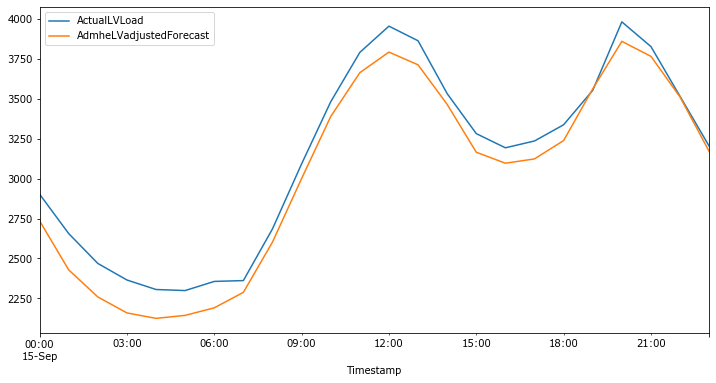

In [59]:
# Plot predictions against known values
ax = plot['ActualLVLoad'].plot(legend=True,figsize=(12,6))
plot['AdmheLVadjustedForecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [60]:
from statsmodels.tools.eval_measures import mse,rmse
Error=rmse(temp,LVp)

In [61]:
Error

131.38859134173126

# SARIMAX

In [62]:
# Auto_Arima
#model=auto_arima(final2['LV'],
 #                     m=24,             
  #                    seasonal=True,   #Seasonality
   #                   exogenous=final2[['Weekday','Holiday']],
    #                  trace=True, error_action='ignore', suppress_warnings=True,stepwise=True)
    

#result=order=(1, 1, 1), seasonal_order=(2, 0, 0, 24)

In [63]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                16056
Model:             SARIMAX(1, 1, 1)x(2, 0, 0, 24)   Log Likelihood              -88508.909
Date:                            Thu, 16 Jan 2020   AIC                         177033.818
Time:                                    13:00:46   BIC                         177095.288
Sample:                                         0   HQIC                        177054.145
                                          - 16056                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2356      0.643     -0.366      0.714      -1.497       1.026
x1             2.5371      0.558      4.547      0.000       1.443       3.631
x2            15.6888      3.236      4.848      0.000       9.346      22.031
ar.L1          0.3601      0.006     60.268      0.000       0.348       0.372
ma.L1          0.4019      0.007     61.620      0.000       0.389       0.415
ar.S.L24       0.6684      0.005    147.943      0.000       0.660       0.677
ar.S.L48       0.2891      0.004     64.722      0.000       0.280       0.298
sigma2      3599.6471     16.098    223.604      0.000    3568.095    3631.199
===================================================================================
Ljung-Box (Q):                     1893.18   Jarque-Bera (JB):            135539.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

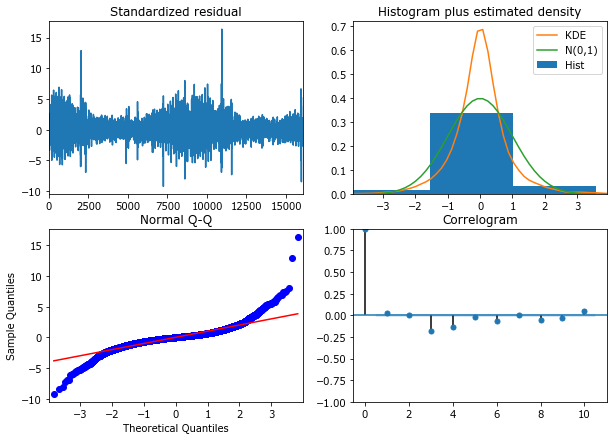

In [64]:
model.plot_diagnostics(figsize=(10,7))
plt.show()

In [62]:
#use the period used for training
df1=final2
df1.shape

(16056, 8)

In [63]:
#train test split
train = df1.loc[:'2019-09-15'].iloc[:-24]
test = df1.loc[:'2019-09-15'].iloc[-24:]

In [65]:
train

,LV,Weekday,Holiday,LVForecastEstimation,%LVofTotal,ActualTotal,Deviation,ForecastTotalLoad
Timestamp,,,,,,,,
2018-01-01 00:00:00,3933.209685,1,1,3928.618104,0.739157,5321.211918,6.211918,5315.0
2018-01-01 01:00:00,3615.862294,1,1,3584.743969,0.722294,5006.082645,43.082645,4963.0
2018-01-01 02:00:00,3531.408073,1,1,3481.997027,0.719718,4906.653316,68.653316,4838.0
2018-01-01 03:00:00,3250.926682,1,1,3171.205588,0.702371,4628.502808,113.502808,4515.0
2018-01-01 04:00:00,3027.204711,1,1,2874.047836,0.671507,4508.079510,228.079510,4280.0
...,...,...,...,...,...,...,...,...
2019-09-14 19:00:00,3708.124552,6,0,3735.084427,0.623866,5943.785777,-43.214223,5987.0
2019-09-14 20:00:00,4076.138779,6,0,4086.716767,0.650958,6261.750132,-16.249868,6278.0
2019-09-14 21:00:00,3848.413260,6,0,3862.376071,0.646315,5954.396263,-21.603737,5976.0


In [67]:
#run model
model = SARIMAX(train['LV'],
                exog=train[['Holiday','Weekday']],
                order=(1, 1, 1),
                seasonal_order=(2, 0, 0, 24),trend='t',
                enforce_invertibility=False,enforce_stationarity=False)#initialization='approximate_diffuse'
results = model.fit()
results.summary()

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                 LV   No. Observations:                14928
Model:             SARIMAX(1, 1, 1)x(2, 0, 0, 24)   Log Likelihood              -85532.479
Date:                            Fri, 17 Jan 2020   AIC                         171080.958
Time:                                    11:29:32   BIC                         171141.820
Sample:                                01-01-2018   HQIC                        171101.159
                                     - 09-14-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -4.954e-05    4.7e-05     -1.055      0.292      -0.000    4.25e-05
Holiday       23.3105      7.753      3.007      0.003       8.114      38.507
Weekday       -1.1233      1.087     -1.034      0.301      -3.253       1.006
ar.L1          0.7316      0.014     54.150      0.000       0.705       0.758
ma.L1         -0.5305      0.015    -35.227      0.000      -0.560      -0.501
ar.S.L24       0.8738      0.007    128.989      0.000       0.860       0.887
ar.S.L48       0.0759      0.007     10.839      0.000       0.062       0.090
sigma2      7225.0419     59.675    121.074      0.000    7108.081    7342.002
===================================================================================
Ljung-Box (Q):                     9038.48   Jarque-Bera (JB):             64402.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['Holiday','Weekday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, 
                              end=end, 
                              exog=exog_forecast).rename('Our Prediction')

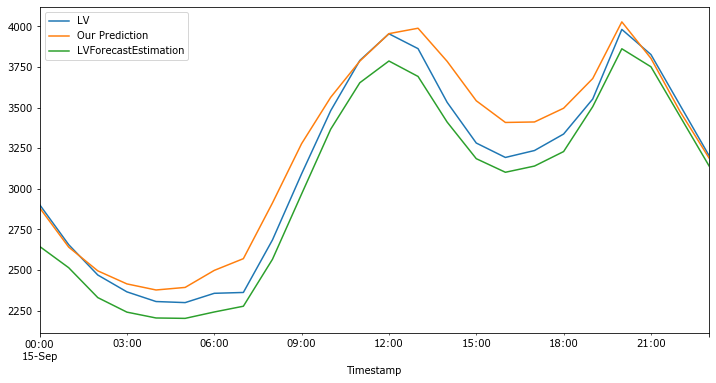

In [73]:
# Plot predictions against known values
ax = test['LV'].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
final['LVForecastEstimation'].loc['2019-09-15'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [74]:
from statsmodels.tools.eval_measures import mse,rmse
#calculate rmse
OurError= rmse(test['LV'], predictions)
TheirError = rmse(final['LVForecastEstimation'].loc['2019-09-15'], test['LV'])

In [75]:
TheirError#if they knew exactly the percentage of LV, which can not be done. This will be our metric, something like 
#best case scenario based on their forecast.

123.23233504842186

In [76]:
OurError

136.03294382134655

# Prophet

In [77]:
#import ProphetLibrary
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [78]:
#create weekday Dataframe for possible use by Prophet
temp=test.reset_index()
tholiday= pd.DataFrame({
    'ds': temp['Timestamp'],
    'Holiday': temp['Holiday']
})
tholiday

,ds,Holiday
0,2019-09-15 00:00:00,0
1,2019-09-15 01:00:00,0
2,2019-09-15 02:00:00,0
3,2019-09-15 03:00:00,0
4,2019-09-15 04:00:00,0
5,2019-09-15 05:00:00,0
6,2019-09-15 06:00:00,0
7,2019-09-15 07:00:00,0
8,2019-09-15 08:00:00,0
9,2019-09-15 09:00:00,0


In [79]:
#create weekday Dataframe for possible use by Prophet
temp=train.reset_index()
holiday= pd.DataFrame({
    'ds': temp['Timestamp'],
    'Holiday': temp['Holiday']
})
holiday

,ds,Holiday
0,2018-01-01 00:00:00,1
1,2018-01-01 01:00:00,1
2,2018-01-01 02:00:00,1
3,2018-01-01 03:00:00,1
4,2018-01-01 04:00:00,1
...,...,...
14923,2019-09-14 19:00:00,0
14924,2019-09-14 20:00:00,0
14925,2019-09-14 21:00:00,0
14926,2019-09-14 22:00:00,0


In [80]:
#create train weekday Dataframe for possible use by Prophet
temp=train.reset_index()
weekday = pd.DataFrame({
    'ds': temp['Timestamp'],
    'weekday': temp['Weekday']
})
weekday

,ds,weekday
0,2018-01-01 00:00:00,1
1,2018-01-01 01:00:00,1
2,2018-01-01 02:00:00,1
3,2018-01-01 03:00:00,1
4,2018-01-01 04:00:00,1
...,...,...
14923,2019-09-14 19:00:00,6
14924,2019-09-14 20:00:00,6
14925,2019-09-14 21:00:00,6
14926,2019-09-14 22:00:00,6


In [81]:
#create test weekday Dataframe for possible use by Prophet
temp=test.reset_index()
tweekday = pd.DataFrame({
    'ds': temp['Timestamp'],
    'weekday': temp['Weekday']
})
tweekday

,ds,weekday
0,2019-09-15 00:00:00,7
1,2019-09-15 01:00:00,7
2,2019-09-15 02:00:00,7
3,2019-09-15 03:00:00,7
4,2019-09-15 04:00:00,7
5,2019-09-15 05:00:00,7
6,2019-09-15 06:00:00,7
7,2019-09-15 07:00:00,7
8,2019-09-15 08:00:00,7
9,2019-09-15 09:00:00,7


In [82]:
train1=pd.merge(weekday, holiday, left_on='ds', right_on='ds', how='left')

In [83]:
test1=pd.merge(tweekday, tholiday, left_on='ds', right_on='ds', how='left')

In [84]:
train['LV']

Timestamp
2018-01-01 00:00:00    3933.209685
2018-01-01 01:00:00    3615.862294
2018-01-01 02:00:00    3531.408073
2018-01-01 03:00:00    3250.926682
2018-01-01 04:00:00    3027.204711
                          ...     
2019-09-14 19:00:00    3708.124552
2019-09-14 20:00:00    4076.138779
2019-09-14 21:00:00    3848.413260
2019-09-14 22:00:00    3511.139159
2019-09-14 23:00:00    3214.702314
Freq: H, Name: LV, Length: 14928, dtype: float64

In [85]:
fs=pd.merge(train['LV'].reset_index().rename(columns={'Timestamp':'ds', 'LV':'y'}), train1, left_on='ds', right_on='ds', how='left')

In [86]:
fs.rename(columns={'Holiday':'holiday'}, inplace=True)
test1.rename(columns={'Holiday':'holiday'}, inplace=True)

In [87]:
fs2=fs.append(test1)

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [88]:
fs2

,ds,holiday,weekday,y
0,2018-01-01 00:00:00,1,1,3933.209685
1,2018-01-01 01:00:00,1,1,3615.862294
2,2018-01-01 02:00:00,1,1,3531.408073
3,2018-01-01 03:00:00,1,1,3250.926682
4,2018-01-01 04:00:00,1,1,3027.204711
...,...,...,...,...
19,2019-09-15 19:00:00,0,7,NaN
20,2019-09-15 20:00:00,0,7,NaN
21,2019-09-15 21:00:00,0,7,NaN
22,2019-09-15 22:00:00,0,7,NaN


In [89]:
#fit Prophet model
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True,growth='linear'
                    ,seasonality_mode='multiplicative',changepoint_prior_scale=50,seasonality_prior_scale=50,holidays_prior_scale=30
                     )#.add_seasonality(name='daily',period=24,fourier_order=20).add_seasonality(name='weekly',period=168,fourier_order=20)
prophet_model.add_regressor('holiday')
prophet_model.add_regressor('weekday')
prophet_model.fit(fs)

In [90]:
#predict
prophet_forecast = prophet_model.predict(fs2[['ds','holiday','weekday']])

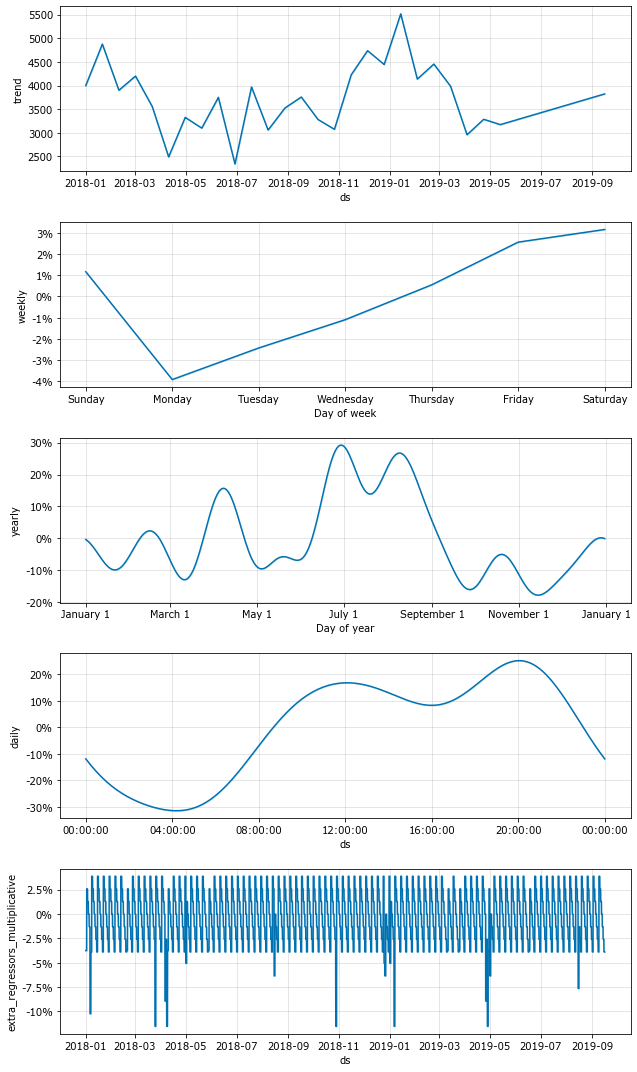

In [91]:
#store predictions
_ = prophet_model.plot_components(prophet_forecast)

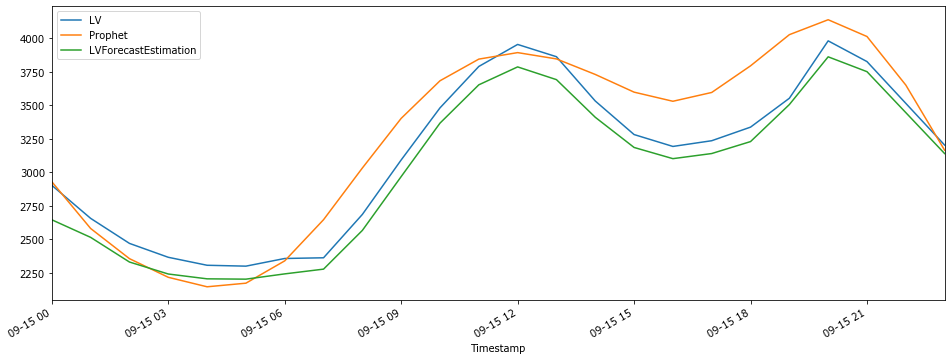

In [92]:
# Plot predictions against known values
fig, axes = plt.subplots(1, figsize=(16,6))
axes.plot(test.index, test['LV'], label='LV')
axes.plot(test.index, prophet_forecast['yhat'].tail(24), label='Prophet', axes=axes)
final['LVForecastEstimation'].loc['2019-09-15'].plot(legend=True, axes=axes)
axes.autoscale(axis='x', tight=True)
axes.legend()

In [93]:
#calculate Error
from statsmodels.tools.eval_measures import mse,rmse
prophet_error= rmse(test['LV'], prophet_forecast['yhat'].tail(24))

In [94]:
#worse
prophet_error

235.2087046210609

# LSTM 

In [92]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))

In [93]:
#final_lstm_multi = final[['Weekday','LV','Holiday']]
final_lstm_multi = final2[['Weekday','LV','Holiday']]
final_lstm_multi = pd.DataFrame(final_lstm_multi)
final_lstm_multi= final_lstm_multi.loc['2018-01-01':'2019-10-31']
final_lstm_multi.head()

,Weekday,LV,Holiday
Timestamp,,,
2018-01-01 00:00:00,1,3933.209685,1
2018-01-01 01:00:00,1,3615.862294,1
2018-01-01 02:00:00,1,3531.408073,1
2018-01-01 03:00:00,1,3250.926682,1
2018-01-01 04:00:00,1,3027.204711,1


In [94]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler


ct = ColumnTransformer([
        ("weekday", OneHotEncoder(categories='auto'), [0]),
        ("LV", MinMaxScaler(feature_range=(0,1)), [1]),
        ("holiday", "passthrough", [2])],
        sparse_threshold=0)

In [95]:
final_lstm_multi['LV']=sc.fit_transform(final_lstm_multi[['LV']])

In [96]:
dataset = ct.fit_transform(final_lstm_multi.values)
dataset[0:100:10]

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.40280533, 1.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.4197427 , 1.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.52861615, 1.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.21481504, 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.45699946, 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.22887572, 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.527287  , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.51736151, 0.        ],


In [97]:
import tensorflow as tf
tf.enable_eager_execution()
tf.executing_eagerly()

True

In [98]:
TRAIN_SPLIT = dataset.shape[0] * 2 // 3
TRAIN_SPLIT

10704

In [99]:
STEP = 1 # We are going to use all samples

In [100]:
def multivariate_data(dataset, target, start_index, end_index, 
                      history_size, target_size, 
                      step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [101]:
past_history = 15 * 24 # 15 days in the past
future_target = 24 # one day in the future

In [102]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, -2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, -2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [103]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('Target load to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (360, 9)
Target load to predict : (24,)


In [104]:
BATCH_SIZE = 256
BUFFER_SIZE = x_train_multi.shape[0]
BUFFER_SIZE

10344

In [105]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [106]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(16, 10))
    num_in = [ x for x in range(-int(history.shape[0]), 0, 1)]
    num_out = int(true_future.shape[0])

    plt.plot(num_in, np.array(history[:, -2]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 
             color='green',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 
                 color='brown',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

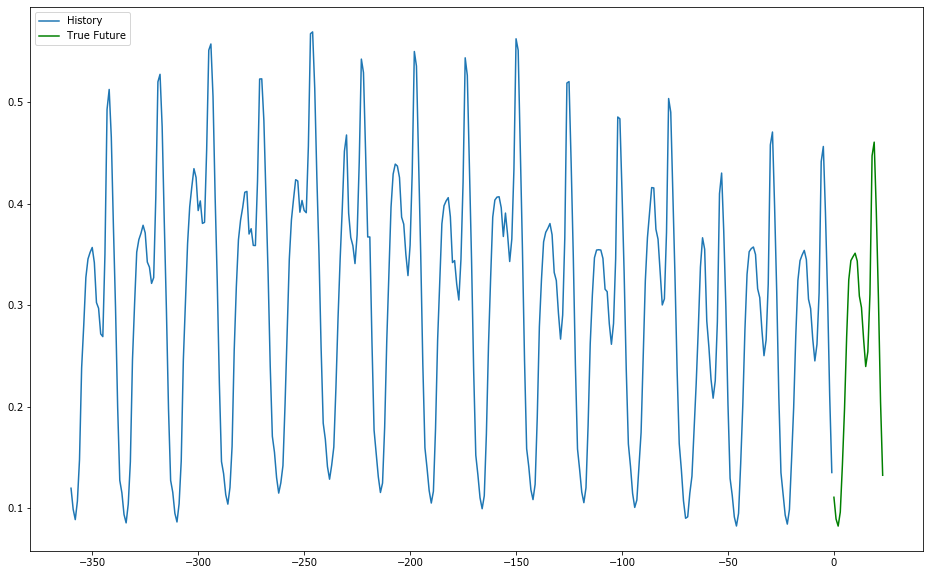

In [107]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [108]:
multivariate_model = tf.keras.models.Sequential()
multivariate_model.add(tf.keras.layers.LSTM(units=100, return_sequences=True, 
                                            input_shape=x_train_multi.shape[-2:]))
multivariate_model.add(tf.keras.layers.LSTM(units=100, return_sequences=True))
multivariate_model.add(tf.keras.layers.LSTM(units=50))
multivariate_model.add(tf.keras.layers.Dense(units=24))
multivariate_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 360, 100)          44000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 360, 100)          80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 24)                1224      
Total params: 155,824
Trainable params: 155,824
Non-trainable params: 0
_________________________________________________________________


In [109]:
multivariate_model.compile(optimizer='adam', loss='mean_squared_error')

In [110]:
for x, y in val_data_multi.take(1):
    print (multivariate_model.predict(x).shape)

(256, 24)


In [111]:
multivariate_history = multivariate_model.fit(train_data_multi, 
                                              epochs=15,
                                              steps_per_epoch=x_train_multi.shape[0] / BATCH_SIZE,
                                              validation_data=val_data_multi,
                                              validation_steps=50)

Train for 40.40625 steps, validate for 50 steps
Epoch 1/15


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


41/40 [==============================] - 187s 5s/step - loss: 0.0491 - val_loss: 0.0176
Epoch 2/15
41/40 [==============================] - 176s 4s/step - loss: 0.0200 - val_loss: 0.0153
Epoch 3/15
41/40 [==============================] - 186s 5s/step - loss: 0.0140 - val_loss: 0.0068
Epoch 4/15
41/40 [==============================] - 200s 5s/step - loss: 0.0064 - val_loss: 0.0048
Epoch 5/15
41/40 [==============================] - 216s 5s/step - loss: 0.0046 - val_loss: 0.0038
Epoch 6/15
41/40 [==============================] - 234s 6s/step - loss: 0.0035 - val_loss: 0.0033
Epoch 7/15
41/40 [==============================] - 252s 6s/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/15
41/40 [==============================] - 275s 7s/step - loss: 0.0027 - val_loss: 0.0027
Epoch 9/15
41/40 [==============================] - 293s 7s/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/15
41/40 [==============================] - 313s 8s/step - loss: 0.0024 - val_loss: 0.0031
Epoch 11/15
41/40 [=

In [112]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

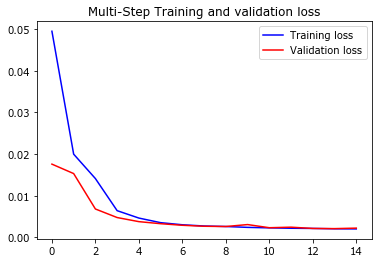

In [113]:
plot_train_history(multivariate_history, 'Multi-Step Training and validation loss')

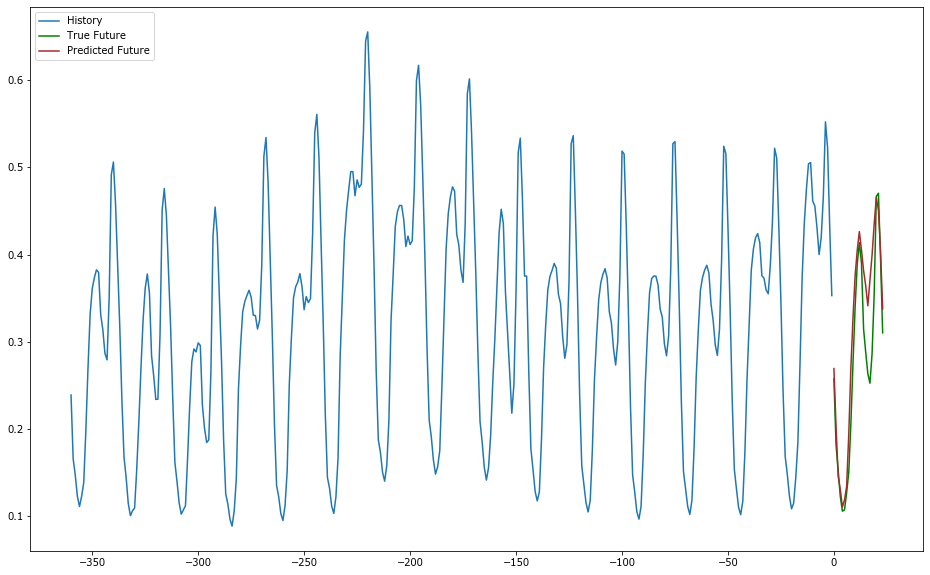

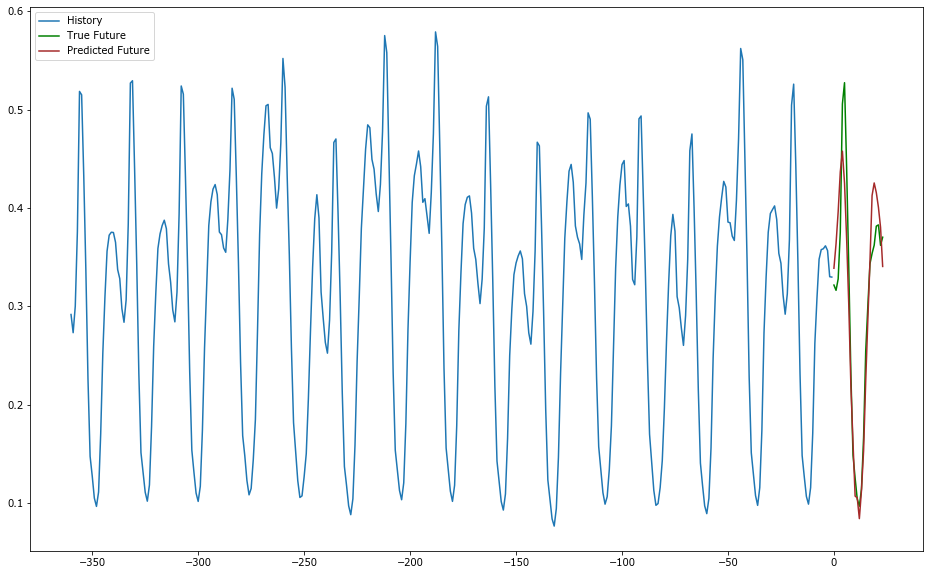

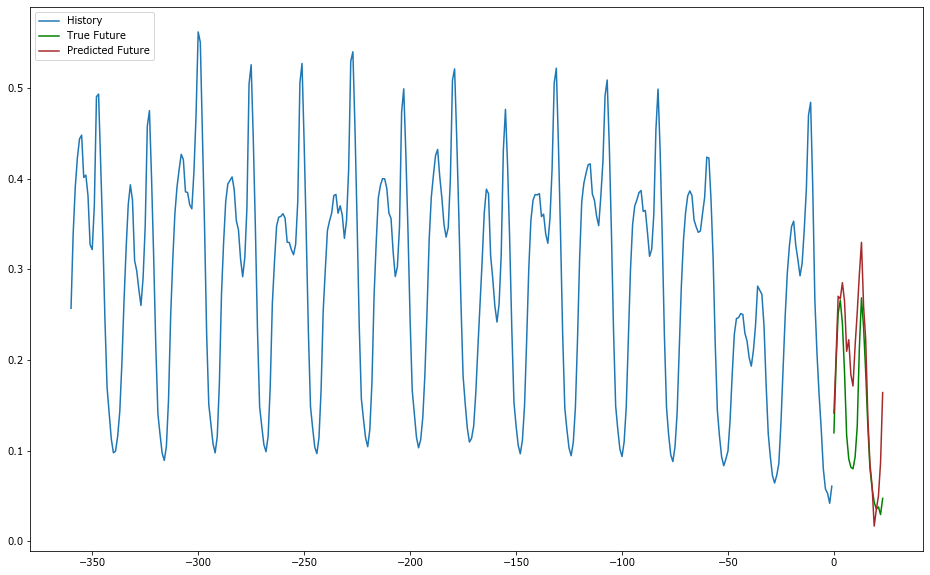

In [114]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multivariate_model.predict(x)[0])

In [115]:
from statsmodels.tools.eval_measures import mse,rmse
def evaluate_LSTM(z,y):
    scores=[]
    for i in range(0,z.shape[0]):
    
        trainPredict_dataset_like=np.zeros(shape=(len(z[i]),3))
        trainPredict_dataset_like[:,1]=z[i]
        Predict=sc.inverse_transform(trainPredict_dataset_like)[:,1]
    
        actual_dataset_like=np.zeros(shape=(len(np.asarray(y[i])),3))
        actual_dataset_like[:,1]=np.asarray(y[i])
        actual=sc.inverse_transform(actual_dataset_like)[:,1]
        scores.append(rmse(Predict,actual))
    
    return scores, sum(scores) / len(scores)

In [116]:
evaluate_LSTM(multivariate_model.predict(x),y)

([376.883151322759,
  363.5743336762339,
  366.9125730674614,
  367.93318846589955,
  369.33343370295114,
  368.5007534796934,
  342.89873402966316,
  309.9899679056632,
  280.78155722333184,
  271.1516178717124,
  278.13973249714263,
  288.2545747992916,
  283.0579757965733,
  234.32329998089023,
  180.8827484574619,
  147.09261287855483,
  127.13986427294857,
  160.67861096578255,
  188.01153869266392,
  202.6318725918143,
  213.73492405407185,
  221.20635042182056,
  221.4256457200936,
  202.55567023787864,
  185.4002213117216,
  183.76056099009082,
  170.22809322915126,
  139.7879783407564,
  110.33006371079907,
  124.51329360016257,
  121.92728220648422,
  112.52764563831717,
  116.65592284813046,
  139.26007369370396,
  159.60672103611654,
  195.84752248018788,
  212.893388546906,
  203.5480742108715,
  190.52840320781536,
  189.39046908426954,
  194.6040045564828,
  209.4143283532356,
  212.75379267138683,
  200.99250873836212,
  183.4805841198808,
  189.0062103905104,
  192.037

In [64]:
final2['Timestamp'] = final2.index

final2['Day'] = pd.to_numeric(final2['Timestamp'].dt.strftime('%d'))
final2['Month'] = pd.to_numeric(final2['Timestamp'].dt.strftime('%m'))
final2['Year'] = pd.to_numeric(final2['Timestamp'].dt.strftime('%Y'))
final2['Hour'] = pd.to_numeric(final2['Timestamp'].dt.strftime('%H'))

In [65]:
final2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16056 entries, 2018-01-01 00:00:00 to 2019-10-31 23:00:00
Freq: H
Data columns (total 13 columns):
LV                      16056 non-null float64
Weekday                 16056 non-null int64
Holiday                 16056 non-null int64
LVForecastEstimation    16056 non-null float64
%LVofTotal              16056 non-null float64
ActualTotal             16056 non-null float64
Deviation               16056 non-null float64
ForecastTotalLoad       16056 non-null float64
Timestamp               16056 non-null datetime64[ns]
Day                     16056 non-null int64
Month                   16056 non-null int64
Year                    16056 non-null int64
Hour                    16056 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(6)
memory usage: 2.3 MB


In [66]:
final2

,LV,Weekday,Holiday,LVForecastEstimation,%LVofTotal,ActualTotal,Deviation,ForecastTotalLoad,Timestamp,Day,Month,Year,Hour
Timestamp,,,,,,,,,,,,,
2018-01-01 00:00:00,3933.209685,1,1,3928.618104,0.739157,5321.211918,6.211918,5315.0,2018-01-01 00:00:00,1,1,2018,0
2018-01-01 01:00:00,3615.862294,1,1,3584.743969,0.722294,5006.082645,43.082645,4963.0,2018-01-01 01:00:00,1,1,2018,1
2018-01-01 02:00:00,3531.408073,1,1,3481.997027,0.719718,4906.653316,68.653316,4838.0,2018-01-01 02:00:00,1,1,2018,2
2018-01-01 03:00:00,3250.926682,1,1,3171.205588,0.702371,4628.502808,113.502808,4515.0,2018-01-01 03:00:00,1,1,2018,3
2018-01-01 04:00:00,3027.204711,1,1,2874.047836,0.671507,4508.079510,228.079510,4280.0,2018-01-01 04:00:00,1,1,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-31 19:00:00,4050.675054,4,0,3961.302143,0.659009,6146.617165,135.617165,6011.0,2019-10-31 19:00:00,31,10,2019,19
2019-10-31 20:00:00,3998.556006,4,0,3901.933643,0.659891,6059.421771,146.421771,5913.0,2019-10-31 20:00:00,31,10,2019,20
2019-10-31 21:00:00,3681.134314,4,0,3598.459103,0.651541,5649.891865,126.891865,5523.0,2019-10-31 21:00:00,31,10,2019,21


# Random Forest Regression

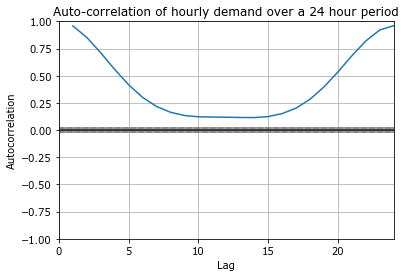

In [67]:
#The autocorrelation plot below shows the extent to which the demand variable correlates with itself at different intervals (lags). 
#This plot shows that demand is highly autocorrelated over the closest 6 hour period.
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(final2['LV'])
plt.xlim(0,24)
plt.title('Auto-correlation of hourly demand over a 24 hour period')
plt.show()

In [68]:
def generate_lagged_features(df, max_lag):
    for t in range(1, max_lag+1):
        df['LV_lag'+str(t)] = df['LV'].shift(t, freq='1H')

In [69]:
generate_lagged_features(final2, 6)

In [70]:
final2

,LV,Weekday,Holiday,LVForecastEstimation,%LVofTotal,ActualTotal,Deviation,ForecastTotalLoad,Timestamp,Day,Month,Year,Hour,LV_lag1,LV_lag2,LV_lag3,LV_lag4,LV_lag5,LV_lag6
Timestamp,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,3933.209685,1,1,3928.618104,0.739157,5321.211918,6.211918,5315.0,2018-01-01 00:00:00,1,1,2018,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 01:00:00,3615.862294,1,1,3584.743969,0.722294,5006.082645,43.082645,4963.0,2018-01-01 01:00:00,1,1,2018,1,3933.209685,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,3531.408073,1,1,3481.997027,0.719718,4906.653316,68.653316,4838.0,2018-01-01 02:00:00,1,1,2018,2,3615.862294,3933.209685,NaN,NaN,NaN,NaN
2018-01-01 03:00:00,3250.926682,1,1,3171.205588,0.702371,4628.502808,113.502808,4515.0,2018-01-01 03:00:00,1,1,2018,3,3531.408073,3615.862294,3933.209685,NaN,NaN,NaN
2018-01-01 04:00:00,3027.204711,1,1,2874.047836,0.671507,4508.079510,228.079510,4280.0,2018-01-01 04:00:00,1,1,2018,4,3250.926682,3531.408073,3615.862294,3933.209685,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-31 19:00:00,4050.675054,4,0,3961.302143,0.659009,6146.617165,135.617165,6011.0,2019-10-31 19:00:00,31,10,2019,19,4008.164369,3551.311406,3207.483538,3262.911283,3488.646619,3608.437275
2019-10-31 20:00:00,3998.556006,4,0,3901.933643,0.659891,6059.421771,146.421771,5913.0,2019-10-31 20:00:00,31,10,2019,20,4050.675054,4008.164369,3551.311406,3207.483538,3262.911283,3488.646619
2019-10-31 21:00:00,3681.134314,4,0,3598.459103,0.651541,5649.891865,126.891865,5523.0,2019-10-31 21:00:00,31,10,2019,21,3998.556006,4050.675054,4008.164369,3551.311406,3207.483538,3262.911283


In [71]:
final2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16056 entries, 2018-01-01 00:00:00 to 2019-10-31 23:00:00
Freq: H
Data columns (total 19 columns):
LV                      16056 non-null float64
Weekday                 16056 non-null int64
Holiday                 16056 non-null int64
LVForecastEstimation    16056 non-null float64
%LVofTotal              16056 non-null float64
ActualTotal             16056 non-null float64
Deviation               16056 non-null float64
ForecastTotalLoad       16056 non-null float64
Timestamp               16056 non-null datetime64[ns]
Day                     16056 non-null int64
Month                   16056 non-null int64
Year                    16056 non-null int64
Hour                    16056 non-null int64
LV_lag1                 16055 non-null float64
LV_lag2                 16054 non-null float64
LV_lag3                 16053 non-null float64
LV_lag4                 16052 non-null float64
LV_lag5                 16051 non-null float64
LV_lag6

In [72]:
final2.dropna(how='any', inplace=True)

In [73]:
final2=final2[['Weekday','Holiday','Year','Month','Hour','LV','LV_lag1','LV_lag2','LV_lag3','LV_lag4','LV_lag5','LV_lag6']]

In [74]:
X_train=final2.loc[:'2019-08-31'][['Year','Month','Hour','Weekday','Holiday','LV_lag1','LV_lag2','LV_lag3','LV_lag4','LV_lag5','LV_lag6']]
y_train=final2.loc[:'2019-08-31']['LV']

In [75]:
X_test=final2.loc['2019-09-15':'2019-09-15'][['Year','Month','Hour','Weekday','Holiday','LV_lag1','LV_lag2','LV_lag3','LV_lag4','LV_lag5','LV_lag6']]
y_test=final2.loc['2019-09-15':'2019-09-15']['LV'].to_frame()

In [76]:
y_their=final.loc['2019-09-15':'2019-09-15']['LVForecastEstimation']

# LightGBM

In [77]:
rfc=ltb.LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=1200,
                                learning_rate=0.17, n_estimators=700, max_depth=6,
                           metric='rmse', bagging_fraction=0.8, feature_fraction=0.8, reg_lambda=0.9)

Forecast the same day as the models before in order to be able to compare.

In [78]:
#fit the model
f=rfc.fit(X_train,y_train)

In [79]:
#make predictions
y_1= f.predict(X_test)

In [80]:
from statsmodels.tools.eval_measures import mse,rmse
#calculate rmse
OurError= rmse(y_1, y_test['LV'])

In [81]:
#Our Error for 24 hour predictions
OurError

41.86925936775572

In [82]:
#TheirError for 24 hour predictions
TheirError= rmse(y_their, y_test['LV'])

In [83]:
TheirError

123.23233504842186

In [84]:
#prediction data maniulation
t=pd.DataFrame(y_test.index)
t1=pd.DataFrame({'Pred':y_1})
result = pd.concat([t, t1], axis=1, sort=False)
result.set_index('Timestamp',inplace=True)
t2=pd.DataFrame(final.loc['2019-09-15':'2019-09-15']['LVForecastEstimation'])
result2=pd.concat([result,t2],axis=1,sort=False)
result3=pd.concat([result2,y_test],axis=1,sort=False)

In [85]:
result3.columns = ['Prediction', 'Pred(ADMHE)','Actual']

In [86]:
result3

,Prediction,Pred(ADMHE),Actual
Timestamp,,,
2019-09-15 00:00:00,2923.729727,2645.300607,2902.763294
2019-09-15 01:00:00,2597.638853,2513.984774,2655.955430
2019-09-15 02:00:00,2480.671747,2329.880614,2469.018933
2019-09-15 03:00:00,2401.920159,2240.425081,2365.265871
2019-09-15 04:00:00,2270.882361,2204.395112,2305.693300
2019-09-15 05:00:00,2286.577959,2201.969460,2299.071236
2019-09-15 06:00:00,2344.129066,2241.353874,2356.332090
2019-09-15 07:00:00,2392.790228,2276.785073,2361.557496
2019-09-15 08:00:00,2634.560938,2565.957350,2685.277618


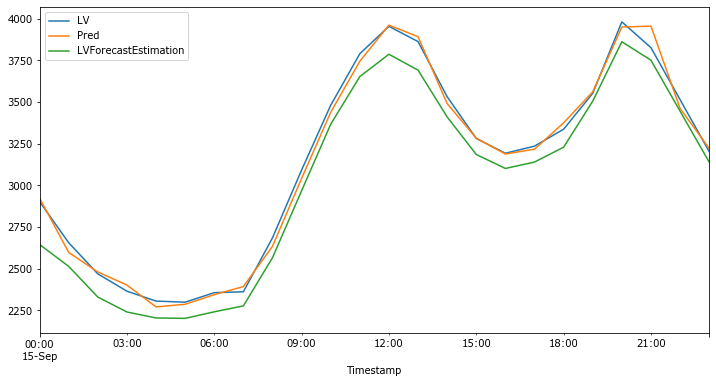

In [87]:
# Plot all of them in different weekly periods
ax = y_test['LV'].loc['2019-09-15':'2019-09-15'].plot(legend=True,figsize=(12,6))
result['Pred'].loc['2019-09-15':'2019-09-15'].plot(legend=True)
y_their.loc['2019-09-15':'2019-09-15'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

# Whole Month Forecast Experiment

In [88]:
X_train=final2.loc[:'2019-08-31'][['Year','Month','Hour','Weekday','Holiday','LV_lag1','LV_lag2','LV_lag3','LV_lag4','LV_lag5','LV_lag6']]
y_train=final2.loc[:'2019-08-31']['LV']

In [89]:
X_test=final2.loc['2019-09-01':'2019-09-30'][['Year','Month','Hour','Weekday','Holiday','LV_lag1','LV_lag2','LV_lag3','LV_lag4','LV_lag5','LV_lag6']]
y_test=final2.loc['2019-09-01':'2019-09-30']['LV'].to_frame()

In [90]:
y_their=final.loc['2019-09-01':'2019-09-30']['LVForecastEstimation']

In [91]:
rfc=ltb.LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=1200,
                                learning_rate=0.17, n_estimators=700, max_depth=6,
                                metric='rmse', bagging_fraction=0.8, feature_fraction=0.8, reg_lambda=0.9)

In [92]:
#fit the model
f=rfc.fit(X_train,y_train)

In [93]:
#make predictions
y_1= f.predict(X_test)

In [94]:
from statsmodels.tools.eval_measures import mse,rmse
#calculate rmse
OurError= rmse(y_1, y_test['LV'])

In [95]:
#Our Error for whole september
OurError

55.73743401618163

In [96]:
TheirError= rmse(y_their, y_test['LV'])

In [97]:
#Their Error for whole september
TheirError

88.1461224329604

In [98]:
#prediction data maniulation
t=pd.DataFrame(y_test.index)
t1=pd.DataFrame({'Pred':y_1})
result = pd.concat([t, t1], axis=1, sort=False)
result.set_index('Timestamp',inplace=True)
t2=pd.DataFrame(final.loc['2019-09-01':'2019-09-30']['LVForecastEstimation'])
result2=pd.concat([result,t2],axis=1,sort=False)
result3=pd.concat([result2,y_test],axis=1,sort=False)


In [99]:
result3.columns = ['Prediction', 'Pred(ADMHE)','Actual']

In [100]:
result3

,Prediction,Pred(ADMHE),Actual
Timestamp,,,
2019-09-01 00:00:00,3547.242845,3499.514338,3549.123970
2019-09-01 01:00:00,3227.961908,3235.462588,3283.696417
2019-09-01 02:00:00,3058.971437,3033.586654,3073.410633
2019-09-01 03:00:00,2916.764421,2900.084989,2928.807426
2019-09-01 04:00:00,2832.191643,2804.914082,2834.027904
...,...,...,...
2019-09-30 19:00:00,3676.885844,3858.535581,3826.308438
2019-09-30 20:00:00,4275.361848,4122.569953,4075.101694
2019-09-30 21:00:00,3827.339670,3813.867927,3763.093504


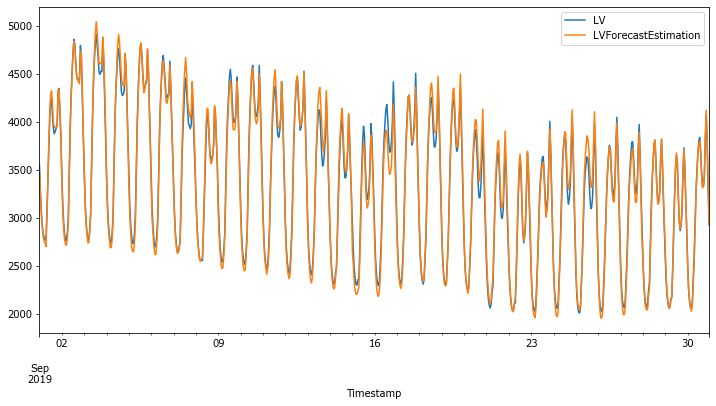

In [101]:
# Plot ADMHE predictions vs actuals
ax = y_test['LV'].plot(legend=True,figsize=(12,6))
y_their.plot(legend=True)
ax.autoscale(axis='x',tight=True)

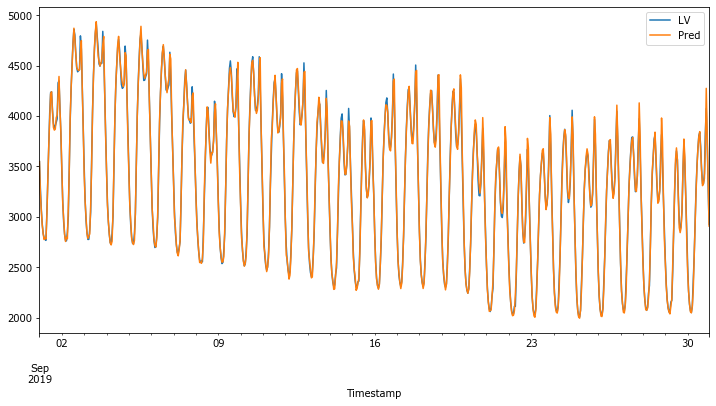

In [102]:
# Plot predictions vs actuals
ax = y_test['LV'].plot(legend=True,figsize=(12,6))
result['Pred'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

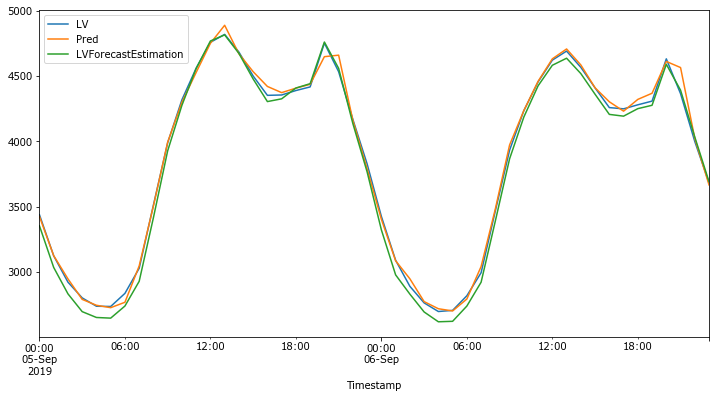

In [103]:
# Plot all of them in different daily periods10
ax = y_test['LV'].loc['2019-09-05':'2019-09-06'].plot(legend=True,figsize=(12,6))
result['Pred'].loc['2019-09-05':'2019-09-06'].plot(legend=True)
y_their.loc['2019-09-05':'2019-09-06'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

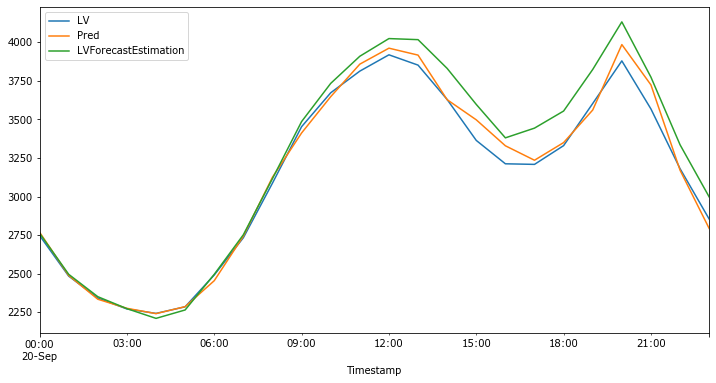

In [104]:
# Plot all of them in different daily periods
ax = y_test['LV'].loc['2019-09-20':'2019-09-20'].plot(legend=True,figsize=(12,6))
result['Pred'].loc['2019-09-20':'2019-09-20'].plot(legend=True)
y_their.loc['2019-09-20':'2019-09-20'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

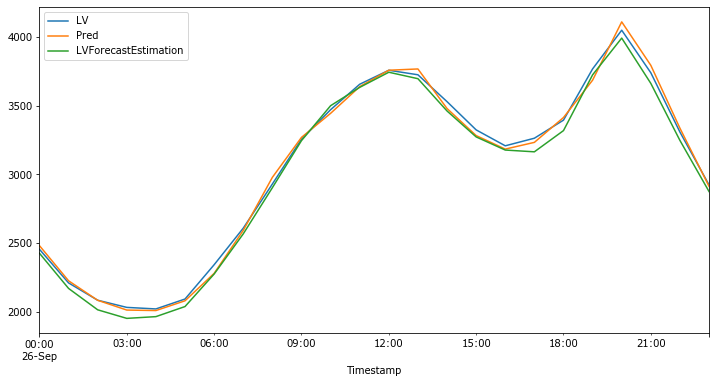

In [105]:
# Plot all of them in different daily periods
ax = y_test['LV'].loc['2019-09-26':'2019-09-26'].plot(legend=True,figsize=(12,6))
result['Pred'].loc['2019-09-26':'2019-09-26'].plot(legend=True)
y_their.loc['2019-09-26':'2019-09-26'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

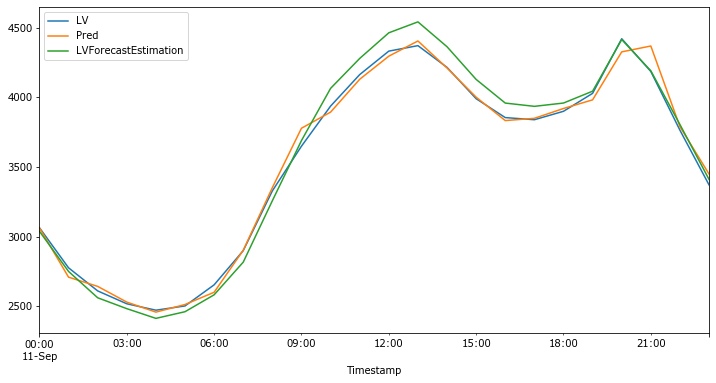

In [106]:
# Plot all of them in different daily periods
ax = y_test['LV'].loc['2019-09-11':'2019-09-11'].plot(legend=True,figsize=(12,6))
result['Pred'].loc['2019-09-11':'2019-09-11'].plot(legend=True)
y_their.loc['2019-09-11':'2019-09-11'].plot(legend=True)
ax.autoscale(axis='x',tight=True)